# `Applied Machine Learning`

## `Lab 4. Sklearn. Data preprocessing`

###Approved by Donat Balaj (dbalaj@constructor.university)

In this assignment we will try to learn how to analyze data and extract useful features from it. We will also learn `sklearn`, and at the same time get used to the basic concepts of machine learning.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [4]:
SEED = 42

## Part 0. Preparation

We will be working with data from the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) competition, in which we had to predict the duration of a taxi trip.

<font color='brown'>**Exercise 1.** Read `train.csv` into the pandas Dataframe:</font>

In [9]:
train_data =  pd.read_csv("train.csv")
train_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


<font color='brown'>**Exercise 2.** Pay attention to the `pickup_datetime` and `dropoff_datetime` columns. `dropoff_datetime` was added by the organizers only to the training set, that is, this column cannot be used, so remove it. `pickup_datetime` contains the start date and time of the trip. To make it easier to work with, convert dates into `datetime` objects:</font>

In [11]:
df = pd.DataFrame(train_data)
df = df.drop(columns='dropoff_datetime')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [12]:
assert isinstance(df.pickup_datetime.iloc[0], pd.Timestamp)
assert set(df.columns).symmetric_difference({
    'id', 'vendor_id', 'pickup_datetime', 'passenger_count',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'trip_duration'
 }) == set()

<font color='brown'>**Exercise 3.** The `trip_duration` column contains the target value that we want to predict. Let's look at the distribution of the target in the training set. To do this, draw its histogram. For better visualization, display values only lower than 0.995 quantile:</font>

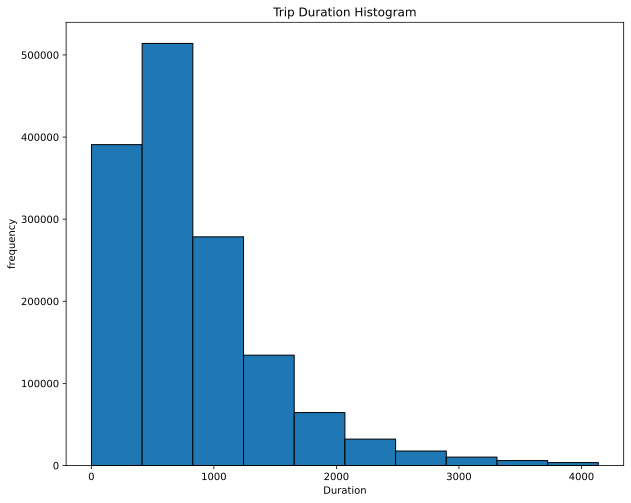

In [14]:
quant = df['trip_duration'].quantile(0.995)
filt = df[df['trip_duration'] < quant]
plt.figure(figsize=(10,8))
plt.hist(filt['trip_duration'], bins = 10, edgecolor = 'black')
plt.xlabel('Duration')
plt.ylabel('frequency')
plt.title('Trip Duration Histogram')
plt.show()

The competition used RMSLE as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

Since the target variable has a heavy-tailed distribution, the chosen metric must be robust to outliers. As you can see from the graph, logarithmic values are more evenly distributed and, therefore, the logarithmic metric is more robust to outliers. Also we want to emphasize the relativity of error. An error between $1$ and $24$ is much more critical than an error between $1000$ and $1001$.

Let's do the following trick: we will predict not the target variable, but its *logarithm*. Let $\hat{y}_i = \log{(y_i + 1)}$ be the modified target, and $\hat{a}(x_i)$ be the prediction of the model that was trained on $\hat{y}_i$, that is, the logarithm of the target. To predict the original value, we can simply take the exponent of our prediction: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

We can show that optimizing RMSLE for model $a$ is equivalent to optimizing MSE for model $\hat{a}:

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2} =
\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = \text{RMSE}(X, \hat{y}, \hat{a})$$
$\text{Note: Monotonic transformations do not change the maxima and minima of the function, so RMSE optimization is equivalent to MSE optimization}\;\;\square$

So, we were able to reduce the RMSLE optimization problem to the MSE optimization problem, which we know how to solve! In addition, taking the logarithm of the target has another useful property.

<font color='brown'>**Exercise 4.** To see it, add the `log_trip_duration` column to our sample (use `np.log1p`) and draw a histogram of the modified target based on the training sample. Delete the column with the old target.</font>

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642


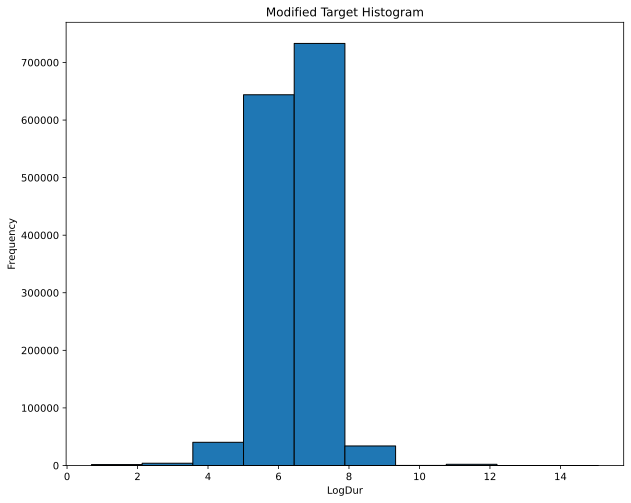

In [23]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df.drop(columns = 'trip_duration')
plt.figure(figsize = (10,8))
plt.hist(df['log_trip_duration'], bins = 10, edgecolor = 'black')
plt.xlabel('LogDur')
plt.ylabel('Frequency')
plt.title('Modified Target Histogram')
df.head()

In [24]:
assert np.isclose(df.log_trip_duration.mean(), 6.4669, atol=1e-4)
assert set(df.columns).symmetric_difference({
    'id', 'vendor_id', 'pickup_datetime', 'passenger_count',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'log_trip_duration'
 }) == set()

AssertionError: 

<font color='brown'>**Exercise 5.** To have some reference point, let's calculate the value of the MSE metric at the best constant prediction:</font>

In [26]:
from sklearn.metrics import mean_squared_error
yb = np.mean(df['log_trip_duration'])
yp = np.full_like(df['log_trip_duration'], yb)

base_mse = mean_squared_error(df['log_trip_duration'], yp) 
base_mse

0.6332327625405553

In [27]:
assert np.abs(base_mse - 0.633232) < 1e-5

## Part 1. Exploring `pickup_datetime`


<font color='brown'>**Exercise 6.** First, let's look at how many trips there were on each day. Graph the number of trips depending on the day of the year</font>

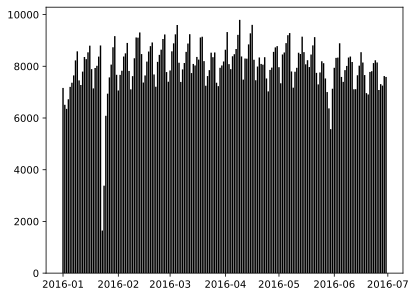

    pickup_datetime  daynum
0        2016-01-01    7162
1        2016-01-02    6512
2        2016-01-03    6353
3        2016-01-04    6725
4        2016-01-05    7204
..              ...     ...
177      2016-06-26    7084
178      2016-06-27    7311
179      2016-06-28    7253
180      2016-06-29    7623
181      2016-06-30    7588

[182 rows x 2 columns]


In [32]:
tbyday = df.groupby(df['pickup_datetime'].dt.date).size()

tbyday = tbyday.reset_index(name = "daynum")

#plt.figure(figsize = (12,6))
plt.bar(tbyday['pickup_datetime'], tbyday['daynum'], color = 'black')
plt.show()
print(tbyday)


You probably noticed that there are 2 periods on the graph with abnormally low numbers of trips.

<font color='brown'>**Exercise 7.** Figure out what dates these downswings occurred and find information about what was happening on those days in New York:</font>

In [35]:
tbyday = df.groupby(df['pickup_datetime'].dt.date).size()
lowval = tbyday.nsmallest(5)
lowval
##on the 23rd, a snowstorm. 

pickup_datetime
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
dtype: int64

<font color='brown'>**Exercise 8.** Draw graphs of the number of trips depending on the day of the week and the hours of the day</font>

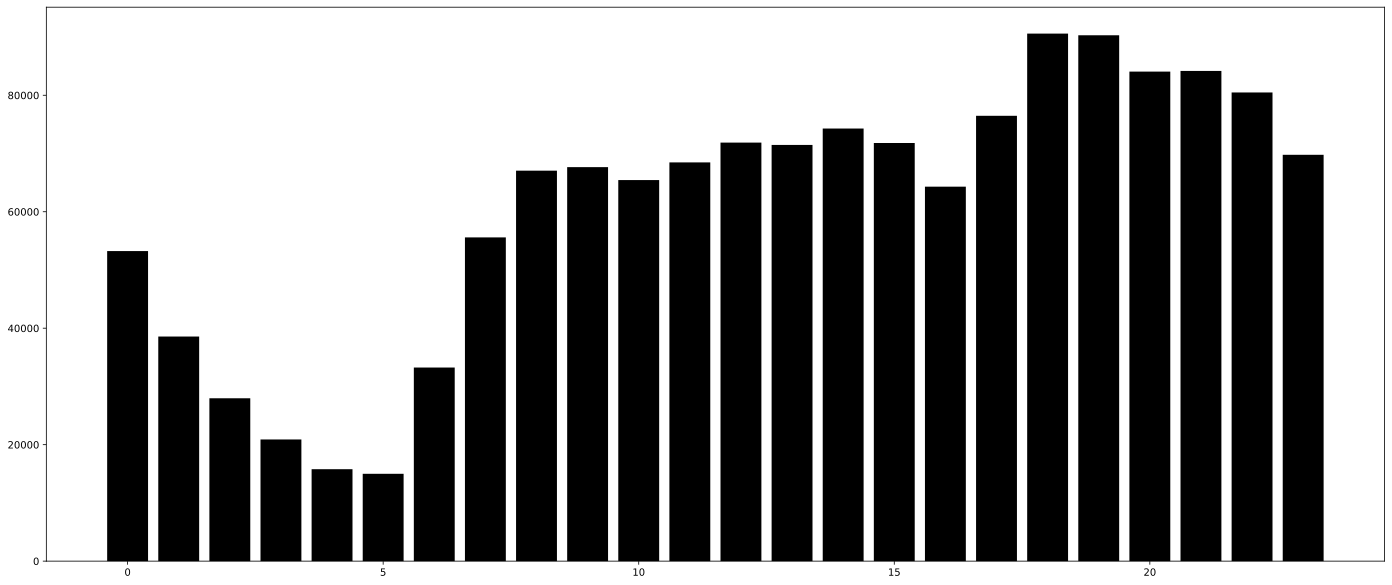

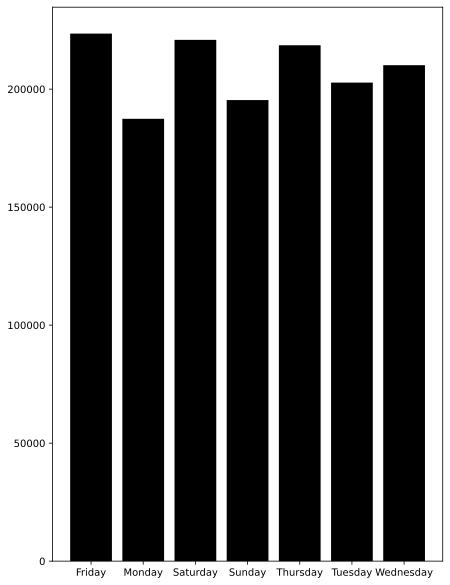

In [38]:
hourly = df.groupby(df['pickup_datetime'].dt.hour).size()
daily = df.groupby(df['pickup_datetime'].dt.day_name()).size()
hourly = hourly.reset_index(name = "tripnum")
daily = daily.reset_index(name = "daynam")
plt.figure(figsize = (24, 10))
plt.bar(hourly['pickup_datetime'], hourly['tripnum'], color = 'black')
plt.figure(figsize = (7, 10))
plt.bar(daily['pickup_datetime'], daily['daynam'], color ='black')
plt.show()

<font color='brown'>**Exercise 9.** Draw on one graph the dependence of the number of trips on an hour in a day for different months</font>

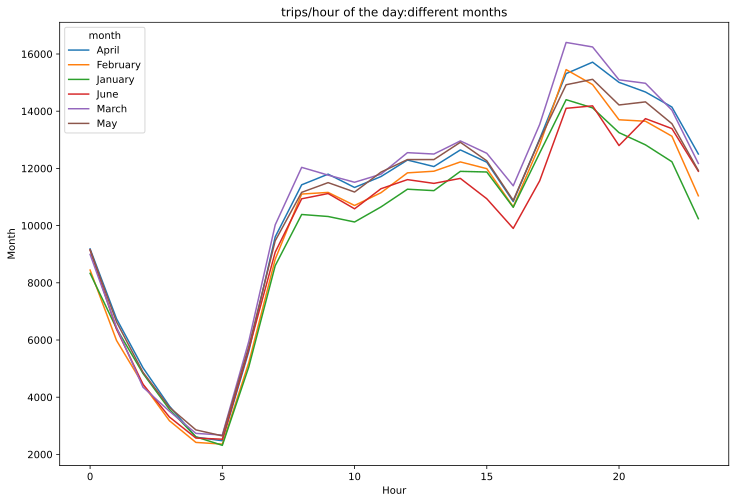

In [41]:
df['hourss'] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month_name()
triphour = df.groupby(['hourss','month']).size().reset_index(name = 'tripc')
plt.figure(figsize = (12,8))
sns.lineplot(data = triphour, x = 'hourss', y = 'tripc', hue = 'month', palette = 'tab10')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.title('trips/hour of the day:different months')
plt.show()

<font color='brown'>**Exercise 10.** Draw on one graph the dependence of the number of trips on an hour in a day for different days of the week</font>

Text(0.5, 1.0, 'dependence of trips on hour/day/different weeks')

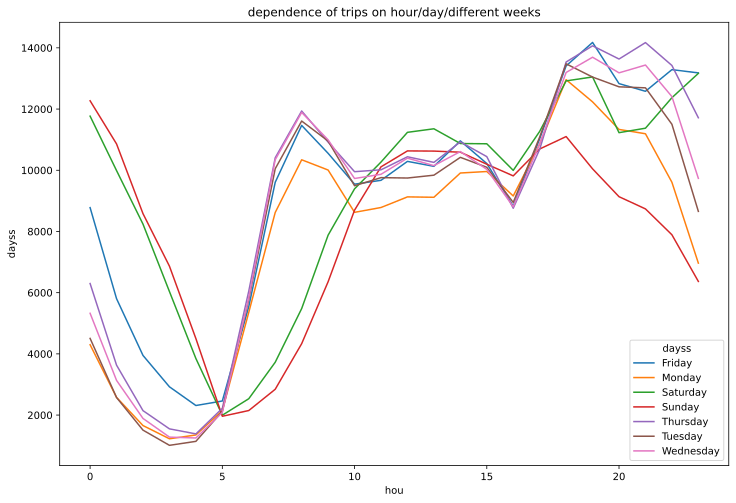

In [44]:
df['hou'] = df['pickup_datetime'].dt.hour
df['dayss'] = df['pickup_datetime'].dt.day_name()
gr = df.groupby(['hou', 'dayss']).size().reset_index(name = 'graphy')
plt.figure(figsize = (12,8))
sns.lineplot(data = gr, x = 'hou', y = 'graphy', hue = 'dayss', palette = 'tab10')
plt.xlabel('hou')
plt.ylabel('dayss')
plt.title('dependence of trips on hour/day/different weeks')

We can see that the most popular call hours are from 6 to 9 pm, during rush hour.

The demand for taxis increases on Friday-Saturday, which may be due to the fact that after a good holiday people do not want/are ready to drive a car themselves.

The time to call a taxi depends little on the month, but the latest graph shows that on weekends the demand for taxis peaks much later than on weekdays, around 10-12 noon. On weekdays, people call a taxi to work, so the peak of popularity there occurs at 7-8 o’clock. Because of this difference, by the way, we get relatively blurry data on the 'pickup rate by day hour' graph, because it seems that more people use taxis in the evening, although approximately the same number use them both in the morning and in the evening, it’s just that this is the time in the morning it is more stretched and we do not see a pronounced peak. In addition, you can notice that on weekends the demand for taxis does not decrease so quickly in the evening (from 0 to 5 o’clock).

In general, you can see that weekends and weekdays behave approximately the same, with Friday being the last working day of the week that stands out only a little.

<font color='brown'>**Exercise 11.** Using the training set, draw a graph of the average logarithm of travel time versus the day of the week. Then do the same, but for an hour of the day and a day of the year</font>

In [ ]:

gw = df.groupby(['dayss','log_trip_duration']).size().reset_index(name = 'ltd')
plt.figure(figsize = (15,8))
plt.bar(df['dayss'], df['log_trip_duration'], color= 'black')
plt.show()

The graph of the target depending on the day of the week is similar to the graph of the number of trips depending on the day of the week in that fewer trips are made on weekends and they are shorter. But the peaks in average travel time and number of trips do not coincide. This can most likely be explained by the fact that there are a limited number of taxis, so the more trips made from a certain point, the shorter they will be.

The graph of the target depending on the hour in the day looks almost the same as the graph for the number of trips, with a slight difference at night: fewer trips are made, but their duration remains practically unchanged for the first couple of hours after midnight. You can also notice that during peak hours the average travel time decreases compared to the middle of the day.

During the first anomalous period, during a snowstorm, the duration of trips increased greatly due to bad weather. In addition, many people have postponed their plans and therefore the number of trips has been greatly reduced. In the second abnormal period, we see exactly the opposite situation with the target: the duration of the trip has decreased. Perhaps this was due to the fact that people on the street were caught off guard by bad weather and had to take a taxi somewhere other than the starting point.

You can also note a trend towards an increase in the average travel time over the course of the year.

Based on those observations let's add some new features:

<font color='brown'>**Exercise 13.**
Add the following attributes based on `pickup_datetime`:
1. Day of the week `weekday`
2. Month `month`
3. Hour `hour`
4. Is the period anomalous (two binary features corresponding to two anomalous periods) `is_anomaly_1`, `is_anomaly_2`
5. Number of the day of the year `year_day`

After all remove `id`, `pickup_datetime` from Dataframe

</font>

In [ ]:
df['days'] = df.groupby(['pickup_datetime'].dt.day_name())
print(df)

In [ ]:
assert np.allclose([
    train_data.weekday.mean(), train_data.month.mean(), train_data.hour.mean(),
    train_data.is_anomaly_1.sum(), train_data.is_anomaly_2.sum(), train_data.year_day.mean()
], [3.0503, 3.5168, 13.6064, 1648 + 3383, 5570, 91.8360], atol=1e-4)
assert set(train_data.columns).symmetric_difference({
    'vendor_id', 'passenger_count',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'log_trip_duration',
    'weekday', 'month', 'hour', 'is_anomaly_1', 'is_anomaly_2', 'year_day'
 }) == set()

So, we have already created a number of features. Which features should be considered as categorical and which as numerical?

It is better to consider features that cannot be ordered (or it does not make sense) as categorical ones. Also, categorical features are usually features whose number is much less than the number of samples (at least by an order of magnitude). For example, good categorical features in our dataset include `vendor_id` and binary flags: `store_and_fwd_flag`, `is_anomaly`. Features that are numeric, have natural order like `hour`, `weekday`, `month`, `year_day` also could be considered as categorical because there is no reasonable way to define numeric operations between different values. The only reasonable operation is comparison. Also, ordering hours in a day and days in a week does not provide information for the model, because it will create the misleading impression that Monday and Sunday, 0 o'clock and 23 o'clock are values far from each other.

However, we can notice, that `year_day` has linear correlation by itself with the target, so despite all above mentioned factors we can still use it as a numeric feature.

Now, let's start training our model:

<font color='brown'>**Exercise 14.** Divide the sample into training and testing in a ratio of 7:3.</font>

In [ ]:
from sklearn.model_selection import train_test_split

train, test = ... ### your code here

<font color='brown'>**Exercise 15.** Separate target (`log_trip_duration`) from other features</font>

In [ ]:
train_y, test_y = ... ### your code here
train_X, test_X = ... ### your code here

In [ ]:
assert (train_y.shape, test_y.shape, train_X.shape, test_X.shape) == ((1021050,), (437594,), (1021050, 13), (437594, 13))

We cannot use Linear Models on top of categorical features straight away. So we need further process them.

<font color='brown'>**Exercise 16.** Encode all categorical features using `OneHotEncoder`. Scale numerical features using `StandardScaler`. Use `ColumnTransformer` to process all columns at ones</font>

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
categorical_columns = ['vendor_id', 'store_and_fwd_flag', 'is_anomaly_1', 'is_anomaly_2', 'weekday', 'month', 'hour']
numeric_columns = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year_day']

### your code here

transformer = ... ### your code here
train_X_transformed = ... ### your code here
test_X_transformed = ... ### your code here

train_X_transformed[0], test_X_transformed[0]

(array([ 0.25644648, -0.0983123 ,  0.04790674, -0.14477185,  0.33156884,
         0.62391343,  0.        ,  1.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]),
 array([-0.50534554, -0.18815403, -0.44758964, -0.10814764,  0.24188894,
         1.32198435,  0.        ,  1.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.    

In [ ]:
assert (train_X_transformed.shape, test_X_transformed.shape) == ((1021050, 51), (437594, 51))

Now we are ready to train simple Linear Model.

<font color='brown'>**Exercise 17.** Train `LinearRegression`. Make predictions using trained model and evaluate MSE on them</font>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
### your code here

lr_mse = mean_squared_error(...) ### your code here
lr_mse

0.5965490743208003

In [ ]:
assert lr_mse < 0.6